# Estimation of mean and variance of a stochastic process with a neural network

While it's obvious how to estimate something with a neural network, [I](http://www.stoerr.net) had some trouble finding a way to [asess the correctness of that estimation](https://stackoverflow.com/questions/56206942/how-can-i-predict-the-expected-value-and-the-variance-simultaneously-with-a-neur) - which amounts to estimating the variance of the result. So let's do it ourselves.

Lets try to estimate the mean and the variance of a partially random value. We assume that a variable $y$ is the sum of a function $f(x)$ and a random number of a gaussian distribution with a standard deviation being another function $g(x)$, and try to approximate both $f(x)$ and $g(x)$ by outputs of the neural network.

The basic idea is here to use the [definitions of the variance](https://en.wikipedia.org/wiki/Variance):
$Var(X) = E[(X-E[X])^2]$ or, alternatively, $Var(X) = E[X^2] - E[X]^2$ , where $E[something]$ is the [expected value](https://en.wikipedia.org/wiki/Expected_value) of something. If we use a neural net with the mean_squared_error loss function, the network approximates the expected value of the outputs for each given input, given enough samples, of course.

(Note that this normally not the case for other loss functions. This happens because the first derivation of the mean squared error is just the error - each sample's contribution to the gradient is proportional to the difference of the neural networks output and the true value, and this gets zero when the output is just the expected value for the input.)

In [0]:
#@title Imports and utilities {display-mode: "form"}


import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np
import functools
import itertools
import time
import os
import datetime

print([tf.__version__, pd.__version__, sns.__version__ ,plt.matplotlib.__version__])


# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, min_delta=0.001, verbose=1)
terminate_nan = keras.callbacks.TerminateOnNaN()

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Val Loss')
    plt.semilogy(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val Error')
    # plt.ylim([0,5])
    plt.legend()


['1.13.1', '0.24.2', '0.9.0', '3.0.3']


## Define the function

As a simple test we use $f(x)=2x+1$ and $g(x)=0.7-0.5$ and try to recreate these functions from random samples in the interval [0,1).

In [0]:
x = np.random.random([100000,1])
f = x*2+1
g = 0.7-0.5*x
y=np.random.normal(loc=f,scale=g)

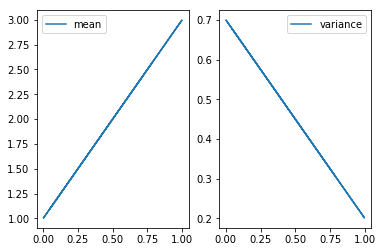

In [0]:
xs = x[:500,:]
plt.subplot(121)
plt.plot(xs,f[:500], label='mean')
plt.legend()
plt.subplot(122)
plt.plot(xs,g[:500], label='variance')
plt.legend()
plt.show()

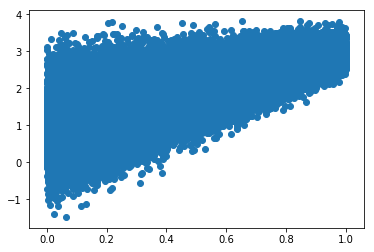

In [0]:
plt.scatter(x,y)
plt.show()

# Estimate the mean
First, we try to estimate only the mean f, ignoring g for now. This is easy: if we use a neural net with the mean_squared_error loss function, the network approximates the expected value of the outputs.

In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, activation=tf.nn.softsign, input_shape=[1]))
# model.add(keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(1))

model.compile(
            optimizer="adam",
            loss=tf.keras.losses.mean_squared_error,
            metrics=['mse', 'acc'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


2019-05-20 19:26:55.643707
Instructions for updating:
Use tf.cast instead.

..................................................
2019-05-20 19:27:33.795693
0.22225946745872496


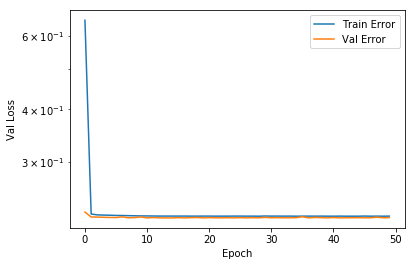

In [0]:
print(datetime.datetime.now())
history = model.fit(x, y, epochs=50, batch_size=128, validation_split=0.1, verbose=0, callbacks=[terminate_nan,early_stop,PrintDot()])
print()
print(datetime.datetime.now())
print(history.history['loss'][-1])
plot_history(history)

We get a quite close match between our original mean function $f(x)$ and the predicted value.

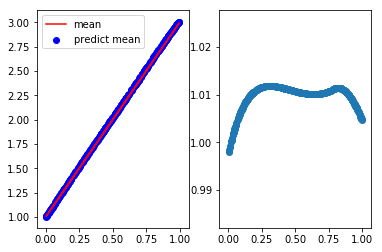

In [0]:
xs = x[:500,:]
predictedMean = model.predict(xs)

plt.subplot(121)
plt.scatter(xs, predictedMean, label='predict mean', color='b')
plt.plot(xs,f[:500],label='mean', color='r')
plt.legend()

plt.subplot(122)
plt.scatter(xs, predictedMean/f[:500],label='mean ratio')
plt.show()

## Prediction of the variance, variant 1



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 130
Trainable params: 130
Non-trainable params: 0
_________________________________________________________________

...................................................................................Epoch 00083: early stopping


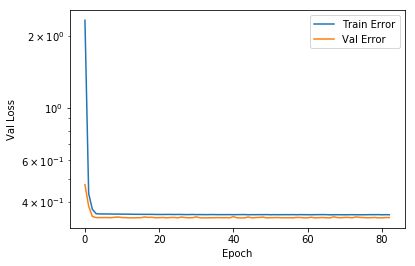

In [0]:
def meanAndVariance(y_true, y_pred):
  y_pred = tf.convert_to_tensor(y_pred)
  y_true = math_ops.cast(y_true, y_pred.dtype)
  mean = y_pred[..., 0::2]
  variance = y_pred[..., 1::2]
  res = K.square(mean - y_true) + K.square(variance - K.square(mean - y_true))
  return K.mean(res, axis=-1)

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Dense(32, activation=tf.nn.softsign, input_shape=[1]
                                 # , kernel_regularizer=keras.regularizers.l2(0.01)
                                ))
# model2.add(keras.layers.Dropout(0.1))
model2.add(tf.keras.layers.Dense(2))
model2.compile(
            optimizer="adam",
            loss=meanAndVariance,
            metrics=['mae', 'acc'])
model2.summary()

history2 = model2.fit(x, y, epochs=250, batch_size=128, validation_split=0.1, verbose=0, callbacks=[terminate_nan,early_stop,PrintDot()])
history2.history['loss'][-1]
plot_history(history2)

If we plot the result in comparison to $f$ and $g$, the result is quite satisfying. We have to compare the square root of the predicted variance to get the standard deviation $g$, of course.

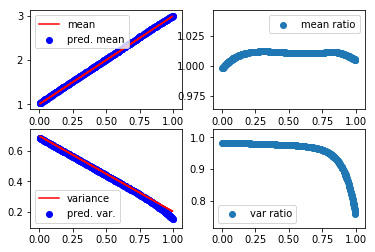

In [0]:
xs = x[:500,:]
predictMean = model2.predict(xs)[:,0:1]
predictStdDev = np.sqrt(model2.predict(xs)[:,1:2])

plt.subplot(221)
plt.scatter(xs,predictMean, label='pred. mean', color='b')
plt.plot(xs,f[:500,:], label='mean', color='r')
plt.legend()

plt.subplot(222)
plt.scatter(xs, predictedMean/f[:500],label='mean ratio')
plt.legend()

plt.subplot(223)
plt.scatter(xs,predictStdDev, label='pred. var.', color='b')
plt.plot(xs,g[:500,:], label='variance', color='r')
plt.legend()

plt.subplot(224)
plt.scatter(xs,predictStdDev/g[:500,:], label='var ratio')
plt.legend()
plt.show()

## Prediction of the variance, variant 2

We can also use the formula $Var(X) = E[X^2] - E[X]^2$ . It is not quite clear to me what's better, but I'd hazard a guess that this is less stable - it might easily get you negative values if the NN is not trained good enough. But on the other hand, it might be easier for the NN to learn this, since in variant 1 the variance output depends on the mean output. Variant 2 is easier to disentangle. But that might not matter at all. 

Anyway, let's try on our toy example. Of course, this simple example is not conclusive, but it seems that the variance estimated not as precise as in variant 1.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 130
Trainable params: 130
Non-trainable params: 0
_________________________________________________________________

.......................................................................Epoch 00071: early stopping


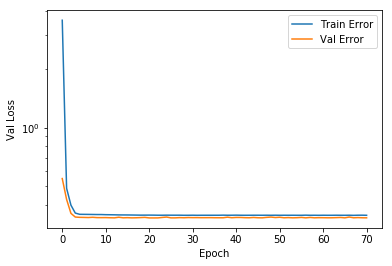

In [0]:
def meanAndMeanSquare(y_true, y_pred):
  y_pred = tf.convert_to_tensor(y_pred)
  y_true = math_ops.cast(y_true, y_pred.dtype)
  mean = y_pred[..., 0::2]
  meanSquare = y_pred[..., 1::2]
  return tf.keras.losses.mean_squared_error(mean, y_true) + tf.keras.losses.mean_squared_error(meanSquare, K.square(y_true))

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Dense(32, activation=tf.nn.softsign, input_shape=[1]
                                 # , kernel_regularizer=keras.regularizers.l2(0.01)
                                ))
# model3.add(keras.layers.Dropout(0.1))
model3.add(tf.keras.layers.Dense(2))
model3.compile(
            optimizer="adam",
            loss=meanAndVariance,
            metrics=['mae', 'acc'])
model3.summary()

history3 = model3.fit(x, y, epochs=250, batch_size=128, validation_split=0.1, verbose=0, callbacks=[terminate_nan,early_stop,PrintDot()])
history3.history['loss'][-1]
plot_history(history3)

Here, we have to calculate the std deviation from the result.

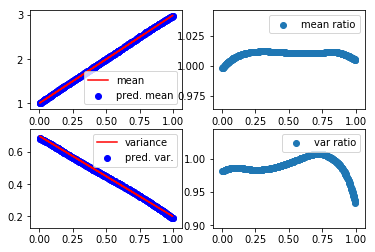

In [0]:
xs = x[:500,:]
predictMean = model3.predict(xs)[:,0:1]
predictStdDev = np.sqrt(model3.predict(xs)[:,1:2])

plt.subplot(221)
plt.scatter(xs,predictMean, label='pred. mean', color='b')
plt.plot(xs,f[:500,:], label='mean', color='r')
plt.legend()

plt.subplot(222)
plt.scatter(xs, predictedMean/f[:500],label='mean ratio')
plt.legend()

plt.subplot(223)
plt.scatter(xs,predictStdDev, label='pred. var.', color='b')
plt.plot(xs,g[:500,:], label='variance', color='r')
plt.legend()

plt.subplot(224)
plt.scatter(xs,predictStdDev/g[:500,:], label='var ratio')
plt.legend()
plt.show()

# Conclusion

With the given Variant 1 it seems quite possible to estimate simultaneously both the expected value (= mean) and the variance (= expected value of the square of the deviation from the mean) for a stochastic value for which both depend on some parameters. How practicable the approach is remains to be tested. :-)

[Hans-Peter Störr](http://www.stoerr.net/), 5/2019